> # **Video Bitrate Prediction using Deep Reinforcement Learning**

**CONCORDIA UNIVERSITY**

**FALL 2023**

**Supervisor:**
Dr. Abdelhak Bentaleb / Assistant Professor / abdelhak.bentaleb@concordia.ca

**Written by:**
Amir Bahador Eizadkhah / Master of Applied Computer Science / eizadkhah.bit@gmail.com


---

The research contains four different parts:


1.   Data Preprocessing
2.   Supervised Learning and LSTM
3.   Overal Results
4.   Adaptive Bitrate Streaming with Q-Learning



---


## **1 DATA PREPROCESSING**

### 1.1 Importing libraries and installing dependancies

In [ ]:
!pip3 install pytube

In [ ]:
# Standard libraries
import os
import subprocess
from numpy.ma.core import count
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import re
import shlex
import cv2
from joblib import dump, load
from numpy.ma.core import mod

# Scikit-learn libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

# XGBoost library
import xgboost as xgb

# TensorFlow and Keras libraries
from keras.layers import (Attention, Concatenate, Dense, Dropout, GlobalAveragePooling1D, Input, LSTM)
from keras.models import Model, load_model
from keras.optimizers import SGD, RMSprop, Adagrad, Adam
from keras.utils import plot_model

# Miscellaneous
from pytube import YouTube

### 1.2 Standardizing Dataset

**SKIP THIS PART IF YOU ARE USING THE PRE-ENCODED VALUES**

In [ ]:
video_directory = '' # Path to the train set

def rename(dataset, video_directory, video_files):
    count = 0
    for idx, video_file in enumerate(video_files, start=1):
        new_filename = f"{idx}.mp4"
        if video_file != new_filename:
            old_path = os.path.join(video_directory, video_file)
            new_path = os.path.join(video_directory, new_filename)
            os.rename(old_path, new_path)
            count += 1
        else:
            print(f"File {video_file} is already in order, skipping renaming.")
    print(f"Renaming {count} number of {dataset} has been finished!")
# Get all video files in the directory
train_video_files = [f for f in os.listdir(video_directory) if f.endswith('.mp4')]

# Sort the files to maintain any existing order (optional but recommended)
train_video_files.sort()

rename("Train set", video_directory, train_video_files)

### 1.3 Video Feature Extraction

#### 1.3.1 Defining the Encoding Ladder

In [ ]:
bitrate_ladder = [
    # Each dictionary in the list represents a resolution and its corresponding bitrates.

    # The first entry for 1920x1080 resolution (Full HD)
    {
        "resolution": "1920x1080",  # Resolution in pixels
        "bitrate_default": 5000,     # Default bitrate in kbps
        "bitrate_min": 2500,         # Minimum bitrate in kbps
        "bitrate_max": 7500          # Maximum bitrate in kbps
    },

    # The second entry for 1280x720 resolution (HD)
    {
        "resolution": "1280x720",   # Resolution in pixels
        "bitrate_default": 2500,     # Default bitrate in kbps
        "bitrate_min": 1500,         # Minimum bitrate in kbps
        "bitrate_max": 3500          # Maximum bitrate in kbps
    },

    # The third entry for 960x540 resolution
    {
        "resolution": "960x540",    # Resolution in pixels
        "bitrate_default": 1000,     # Default bitrate in kbps
        "bitrate_min": 500,          # Minimum bitrate in kbps
        "bitrate_max": 1500          # Maximum bitrate in kbps
    },

    # The fourth entry for 640x360 resolution
    {
        "resolution": "640x360",    # Resolution in pixels
        "bitrate_default": 750,      # Default bitrate in kbps
        "bitrate_min": 400,          # Minimum bitrate in kbps
        "bitrate_max": 1000          # Maximum bitrate in kbps
    },

    # The fifth entry for 480x270 resolution
    {
        "resolution": "480x270",    # Resolution in pixels
        "bitrate_default": 500,      # Default bitrate in kbps
        "bitrate_min": 250,          # Minimum bitrate in kbps
        "bitrate_max": 750           # Maximum bitrate in kbps
    }
]

# This bitrate ladder is used to define various encoding settings for different video resolutions.
# Each setting includes a range of bitrates (min, default, max) to accommodate varying network conditions.

#### 1.3.2 Extracting PSNR

In [ ]:
def calculate_psnr(frame1, frame2):
    mse = np.mean((frame1 - frame2) ** 2)
    if mse == 0:
        return 100  # Identical frames
    PIXEL_MAX = 255.0
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

#### 1.3.3 Exctracting RGB Histogram

In [ ]:
def calculate_histogram(img):
    # Calculate histograms for each channel
    r_hist, _ = np.histogram(img[:, :, 0], bins=256, range=(0, 256))
    g_hist, _ = np.histogram(img[:, :, 1], bins=256, range=(0, 256))
    b_hist, _ = np.histogram(img[:, :, 2], bins=256, range=(0, 256))

    # Normalize the histograms
    r_hist = r_hist / np.sum(r_hist)
    g_hist = g_hist / np.sum(g_hist)
    b_hist = b_hist / np.sum(b_hist)

    # Flatten and concatenate the histograms
    hist_features = np.concatenate((r_hist, g_hist, b_hist))

    return hist_features

#### 1.3.4 Extracting RGB Variance

In [ ]:
def calculate_color_variance(img):
    # Calculate variance for each channel
    r_var = np.var(img[:, :, 0])
    g_var = np.var(img[:, :, 1])
    b_var = np.var(img[:, :, 2])
    return r_var, g_var, b_var

#### 1.3.5 Extracting Frame Difference

In [ ]:
def calculate_frame_difference(frame1, frame2):
    diff = cv2.absdiff(frame1, frame2)
    return np.mean(diff)

#### 1.3.6 Extracting DCT Mean and Variance

The discrete cosine transform (DCT) represents an image as a sum of sinusoids of varying magnitudes and frequencies.

https://www.mathworks.com/help/images/discrete-cosine-transform.html

In [ ]:
def calculate_dct_coefficients(frame):
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Apply DCT
    dct = cv2.dct(np.float32(gray) / 255.0)
    return np.mean(dct), np.var(dct)

#### 1.3.7 Building up the features

In [ ]:
def process_video(original_video_path, encoded_video_path):
    # Initialize video capture for both original and encoded videos
    cap_original = cv2.VideoCapture(original_video_path)
    cap_encoded = cv2.VideoCapture(encoded_video_path)

    # Initialize lists to store various quality metrics
    color_variance_values = []
    psnr_values = []
    frame_diff_values = []
    dct_mean_values = []
    dct_var_values = []
    prev_frame = None

    while True:
        # Read frames from both videos
        ret_orig, frame_orig = cap_original.read()
        ret_enc, frame_enc = cap_encoded.read()

        # Break the loop if no more frames in either video
        if not ret_orig or not ret_enc:
            break

        # Resize encoded frame to match original video's dimensions
        frame_enc_resized = cv2.resize(frame_enc, (frame_orig.shape[1], frame_orig.shape[0]))

        # Convert frames to RGB color space
        frame_orig_rgb = cv2.cvtColor(frame_orig, cv2.COLOR_BGR2RGB)
        frame_enc_rgb = cv2.cvtColor(frame_enc_resized, cv2.COLOR_BGR2RGB)

        # Calculate and store PSNR and color variance
        psnr_values.append(calculate_psnr(frame_orig_rgb, frame_enc_rgb))
        r_var, g_var, b_var = calculate_color_variance(frame_enc_rgb)
        color_variance_values.append((r_var, g_var, b_var))

        # Calculate and store frame difference if previous frame exists
        if prev_frame is not None:
            frame_diff = calculate_frame_difference(prev_frame, frame_enc_rgb)
            frame_diff_values.append(frame_diff)

        # Calculate and store DCT coefficients
        dct_mean, dct_var = calculate_dct_coefficients(frame_enc_rgb)
        dct_mean_values.append(dct_mean)
        dct_var_values.append(dct_var)

        # Update previous frame for next iteration
        prev_frame = frame_enc_rgb

    # Release video captures
    cap_original.release()
    cap_encoded.release()

    # Compute average values for all metrics
    avg_psnr = np.mean(psnr_values) if psnr_values else 0
    avg_color_variance = np.mean(color_variance_values, axis=0) if color_variance_values else (0, 0, 0)
    avg_frame_diff = np.mean(frame_diff_values) if frame_diff_values else 0
    avg_dct_mean = np.mean(dct_mean_values) if dct_mean_values else 0
    avg_dct_var = np.mean(dct_var_values) if dct_var_values else 0

    # Return computed average values
    return avg_psnr, avg_color_variance, avg_frame_diff, avg_dct_mean, avg_dct_var

#### 1.3.8 Creating Dataset

In [ ]:
def create_dataset(encoded_video_directory, original_video_directory, bitrate_ladder):
    # Initialize lists to hold features, labels, and video names
    all_features = []
    all_labels = []
    video_names = []

    # Get all encoded video files from the directory
    encoded_video_files = [f for f in os.listdir(encoded_video_directory) if f.endswith('.mp4')]

    # Process each encoded video file
    for encoded_video_file in tqdm(encoded_video_files, desc="Processing Videos"):
        # Construct paths for encoded and corresponding original video
        encoded_video_path = os.path.join(encoded_video_directory, encoded_video_file)
        original_video_file = find_corresponding_original_file(encoded_video_file)
        original_video_path = os.path.join(original_video_directory, original_video_file)

        # Determine the bitrate category of the encoded video
        label = determine_bitrate(encoded_video_file, bitrate_ladder)

        # If a valid label is found, process the video pair
        if label is not None:
            # Extract quality metrics by processing the video pair
            psnr_value, color_variance, frame_diff, dct_mean, dct_var = process_video(original_video_path, encoded_video_path)

            # Combine all metrics into a single feature list
            feature = [psnr_value] + list(color_variance) + [frame_diff, dct_mean, dct_var]

            # Append the features, label, and video name to their respective lists
            all_features.append(feature)
            all_labels.append(label)
            video_names.append(encoded_video_file)

    # Convert the lists to numpy arrays and return them
    return np.array(all_features), np.array(all_labels), video_names

def find_corresponding_original_file(encoded_video_file):
    # Split the file name by underscores and take the first part
    # This assumes that the original file name is the first part of the encoded file name
    # For example, if the encoded file is "video1_1280x720_2500k.mp4",
    # the original file would be "video1.mp4"
    original_video_name = encoded_video_file.split('_')[0]
    original_video_file = original_video_name + '.mp4'
    return original_video_file

def determine_bitrate(video_file, bitrate_ladder):
    # Iterate through each step in the bitrate ladder
    for step in bitrate_ladder:
        # Extract the resolution part from the video file name
        resolution = video_file.split('_')[1]

        # Check if the resolution matches with the current step in the bitrate ladder
        if resolution == step['resolution']:
            # Extract the bitrate part from the video file name and append 'k' to match the format in the ladder
            bitrate_str = video_file.split('_')[2].replace('k.mp4', '') + 'k'

            # Determine the category of the bitrate based on the bitrate ladder
            # Compare the extracted bitrate string with the min, default, and max bitrates in the ladder
            if bitrate_str == str(step['bitrate_min']) + 'k':
                return 'bitrate_min'  # Return 'bitrate_min' if it matches the minimum bitrate of the step
            elif bitrate_str == str(step['bitrate_default']) + 'k':
                return 'bitrate_default'  # Return 'bitrate_default' if it matches the default bitrate of the step
            elif bitrate_str == str(step['bitrate_max']) + 'k':
                return 'bitrate_max'  # Return 'bitrate_max' if it matches the maximum bitrate of the step

    # Return None if no matching bitrate category is found
    # This can happen if the video file's bitrate doesn't match any of the steps in the ladder
    return None

#### 1.3.9 Saving Encoded Values

**SKIP THIS PART IF YOU ARE USING THE PRE-ENCODED VALUES**

In [ ]:
encoded_folder = '/content/drive/MyDrive/Private/Bahador/Concordia University/6- Fall 2023/COMP 691/Project/Dataset/DS'
un_encoded_folder = '/content/drive/MyDrive/Private/Bahador/Concordia University/6- Fall 2023/COMP 691/Project/Dataset/UN'
# Create dataset
features, bitrate, video_files = create_dataset(encoded_folder, un_encoded_folder, bitrate_ladder)

np.save('/Users/bahador/Documents/COMP691/Dataset/features_values.npy', features)
np.save('/Users/bahador/Documents/COMP691/Dataset/bitrate_values.npy', bitrate)
np.save('/Users/bahador/Documents/COMP691/Dataset/video_files_values.npy', video_files)

print('Dataset creation complete.')

#### 1.3.10 Loading Pre-Encoded Features

In [ ]:
features = np.load('/content/drive/MyDrive/Private/Bahador/Concordia University/6- Fall 2023/COMP 691/Project/Dataset/features.npy')
bitrates = np.load('/content/drive/MyDrive/Private/Bahador/Concordia University/6- Fall 2023/COMP 691/Project/Dataset/bitrates.npy')
videos = np.load('/content/drive/MyDrive/Private/Bahador/Concordia University/6- Fall 2023/COMP 691/Project/Dataset/video_files.npy')

VMAF Score. of 2 similar videos (Original 720p-2100k and Encoded 720p-1500k)

 **1200 frames ⡀⢙ *18.41 FPS***

**vmaf_v0.6.1: *89.116069***



**Frame Processing and FPS (Frames Per Second):**

* 1200 frames ⡀⢙ 18.41 FPS indicates that VMAF processed 1200 frames of this video at an average speed of 18.41 frames per second. This part of the output is more about the performance of the VMAF tool itself rather than the quality of this video. It tells you how many frames were analyzed and how quickly the analysis was done.

**VMAF Score:**

* vmaf_v0.6.1: 89.116069 is the actual VMAF score. VMAF scores range from 0 to 100, with higher scores indicating better video quality. In this case, a score of 89.116069 suggests that the quality of the encoded video (as compared to the original video) is quite high. It means that the encoding process preserved a good amount of the original quality, and the resulting video should have high perceptual quality from a viewer's perspective.

### 1.4 Building 'X' features

In [ ]:
def map_resolution(resolution):
    resolution_map = {
        '1920x1080': 5,
        '1280x720': 4,
        '640x360': 3,
        '480x270': 2,
        '320x180': 1
    }
    return resolution_map.get(resolution, 0)

def map_bitrate(label):
    bitrate_map = {
        'bitrate_max': 3,
        'bitrate_default': 2,
        'bitrate_min': 1
    }
    return bitrate_map.get(label, 0)

resolutions_array = np.array([filename.split('_')[1] for filename in videos]).reshape(-1, 1)
name = ['PSNR', 'R_Var', 'G_Var', 'B_Var', 'Frame_Diff', 'DCT_Mean', 'DCT_Var', 'RES']
features_resolution = np.hstack([features, resolutions_array])

data = np.hstack([features_resolution, bitrates.reshape(-1, 1)])

df = pd.DataFrame(data, columns=name + ['BITRATE'])
df['Video_File'] = videos
df_sorted = df.sort_values(by='Video_File')

df_sorted.head(10)

,PSNR,R_Var,G_Var,B_Var,Frame_Diff,DCT_Mean,DCT_Var,RES,BITRATE,Video_File
8066,33.95293671053613,4068.7482538257145,4254.068021377305,4764.69866633664,5.864203797508983,0.0009727812139317393,0.31869661808013916,1280x720,bitrate_min,100_1280x720_1500k.mp4
6207,34.91659924558106,4082.7101788499654,4262.66188923154,4768.990425480469,5.977583634436898,0.0009732490871101618,0.31893184781074524,1280x720,bitrate_default,100_1280x720_2500k.mp4
4596,35.42764106675804,4090.113050980283,4265.090744110356,4770.146208123299,6.021266507388476,0.0009733643964864314,0.3190264105796814,1280x720,bitrate_max,100_1280x720_3500k.mp4
3256,36.06077620768804,4118.628526903984,4291.274812101624,4796.0520674789295,6.240119417038745,0.0009732802282087505,0.31926530599594116,1920x1080,bitrate_min,100_1920x1080_2500k.mp4
1943,38.29263897779664,4131.692814467591,4301.961009006953,4802.079340943176,6.386515355592392,0.000973080808762461,0.31952425837516785,1920x1080,bitrate_default,100_1920x1080_5000k.mp4
5768,39.28839415956529,4136.430100365422,4305.174171574785,4803.160177458228,6.436815434689593,0.0009730696328915656,0.3196061849594116,1920x1080,bitrate_max,100_1920x1080_7500k.mp4
1595,30.789846196083058,3822.402112193136,4053.1782137894106,4597.993060872368,4.449435343039703,0.000974478549323976,0.31585758924484253,480x270,bitrate_min,100_480x270_250k.mp4
4494,31.255127467383893,3864.200631143623,4078.7528425488085,4623.295778018999,4.6091743651606265,0.0009723124676384032,0.3164522647857666,480x270,bitrate_default,100_480x270_500k.mp4
7706,31.47386597304624,3880.9563989227813,4086.867419797023,4624.709655920893,4.660469704485954,0.0009706257260404527,0.3166578710079193,480x270,bitrate_max,100_480x270_750k.mp4
7533,32.04602357610054,3945.707410124602,4150.255587597839,4675.784091182342,5.042479240271185,0.0009711636230349541,0.31727874279022217,640x360,bitrate_max,100_640x360_1000k.mp4


In [ ]:
df_sorted['Resolution_Score'] = df_sorted['RES'].apply(map_resolution)
df_sorted['Bitrate_Score'] = df_sorted['BITRATE'].apply(map_bitrate)

df_sorted.drop(['BITRATE', 'RES'], axis=1, inplace=True)

X = df_sorted[['PSNR', 'R_Var', 'G_Var', 'B_Var', 'Frame_Diff', 'DCT_Mean', 'DCT_Var','Resolution_Score', 'Bitrate_Score']]
df_sorted.head()

,PSNR,R_Var,G_Var,B_Var,Frame_Diff,DCT_Mean,DCT_Var,Video_File,Resolution_Score,Bitrate_Score
8066,33.95293671053613,4068.7482538257145,4254.068021377305,4764.69866633664,5.864203797508983,0.0009727812139317393,0.31869661808013916,100_1280x720_1500k.mp4,4,1
6207,34.91659924558106,4082.7101788499654,4262.66188923154,4768.990425480469,5.977583634436898,0.0009732490871101618,0.31893184781074524,100_1280x720_2500k.mp4,4,2
4596,35.42764106675804,4090.113050980283,4265.090744110356,4770.146208123299,6.021266507388476,0.0009733643964864314,0.3190264105796814,100_1280x720_3500k.mp4,4,3
3256,36.06077620768804,4118.628526903984,4291.274812101624,4796.0520674789295,6.240119417038745,0.0009732802282087505,0.31926530599594116,100_1920x1080_2500k.mp4,5,1
1943,38.29263897779664,4131.692814467591,4301.961009006953,4802.079340943176,6.386515355592392,0.000973080808762461,0.31952425837516785,100_1920x1080_5000k.mp4,5,2


### 1.5 Building 'y' Labels based on QoE

**Weights Assignment:**
* Each feature (like PSNR, R_Var, etc.) is assigned a weight, indicating its importance in calculating the QoE.
* The weights array contains these weights. A negative weight for bitrate suggests that higher bitrates negatively impact the QoE, which might be counterintuitive unless it's related to costs or resource usage.

**Normalization of Weights:**

* The weights are normalized so that their sum equals 1. This ensures that the weighted sum doesn't favor any feature disproportionately.

**Feature Normalization:**

* Each feature is normalized to a scale of 0 to 1. This is done by subtracting the minimum value of each feature from the feature values and then dividing by the range (max - min).
* This step ensures that all features contribute equally to the final score, regardless of their original scale or units.

**Calculating Raw QoE Score:**

* The normalized features are multiplied by the normalized weights, and the products are summed up to get a raw QoE score for each set of features. This is essentially a weighted average.
* The raw QoE score is then scaled to a range of 0 to 4, which is a common scale for QoE measurements.

**Rounding QoE Scores:**

* Finally, the QoE scores are rounded to the nearest integer for easier interpretation.

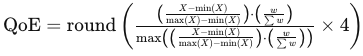

Normalize the weights

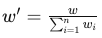

Normalize the featues

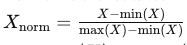

In [ ]:
def calculate_qoe(features):
    # Weights for each feature
    weights = np.array([0.1,  # PSNR
                        0.1,  # R_Var
                        0.1,  # G_Var
                        0.1,  # B_Var
                        0.1,  # Frame_Diff
                        0.1,  # DCT_Mean
                        0.1,  # DCT_Var
                        0.15, # resolution
                        -0.15]) # bitrate

    # Normalize the weights so they sum to 1
    weights /= np.sum(weights)


    features = features.apply(pd.to_numeric, errors='coerce')

    # Normalize the features to a 0-1 scale
    features_min = features.min(axis=0)
    features_max = features.max(axis=0)

    normalized_features = (features - features_min) / (features_max - features_min)
    raw_qoe_score = np.dot(normalized_features, weights)

    # Calculate the raw QoE score as a weighted sum
    max_raw_score = np.dot(np.ones_like(weights), weights)
    qoe_scores = (raw_qoe_score / max_raw_score) * 4

    # Round the QoE scores to the nearest integer
    qoe_scores_rounded = np.round(qoe_scores)

    return qoe_scores_rounded

# Then use this function as you did before
qoe_scores_rounded = calculate_qoe(X)

# Add the rounded QoE scores as a column in the DataFrame
df_sorted['QoE'] = qoe_scores_rounded
# Set 'QoE' column as the target variable
y = df_sorted['QoE']

### 1.6 Data visualization

In [ ]:
df_sorted.head()

,PSNR,R_Var,G_Var,B_Var,Frame_Diff,DCT_Mean,DCT_Var,Video_File,Resolution_Score,Bitrate_Score,QoE
8066,33.95293671053613,4068.7482538257145,4254.068021377305,4764.69866633664,5.864203797508983,0.0009727812139317393,0.31869661808013916,100_1280x720_1500k.mp4,4,1,2.0
6207,34.91659924558106,4082.7101788499654,4262.66188923154,4768.990425480469,5.977583634436898,0.0009732490871101618,0.31893184781074524,100_1280x720_2500k.mp4,4,2,2.0
4596,35.42764106675804,4090.113050980283,4265.090744110356,4770.146208123299,6.021266507388476,0.0009733643964864314,0.3190264105796814,100_1280x720_3500k.mp4,4,3,1.0
3256,36.06077620768804,4118.628526903984,4291.274812101624,4796.0520674789295,6.240119417038745,0.0009732802282087505,0.31926530599594116,100_1920x1080_2500k.mp4,5,1,2.0
1943,38.29263897779664,4131.692814467591,4301.961009006953,4802.079340943176,6.386515355592392,0.000973080808762461,0.31952425837516785,100_1920x1080_5000k.mp4,5,2,2.0


Class Distribution: {0.0: 716, 1.0: 4968, 2.0: 3194, 3.0: 122}


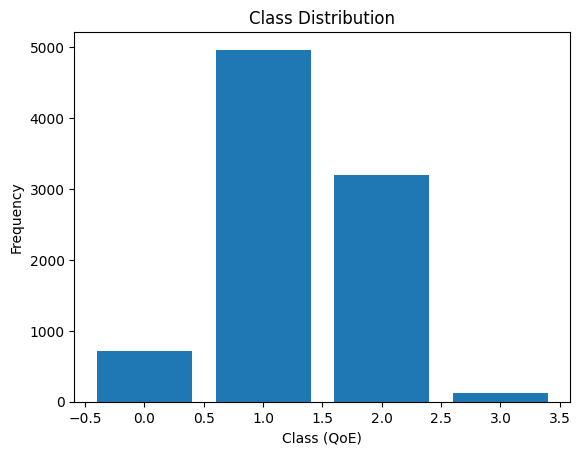

In [ ]:
unique, counts = np.unique(y, return_counts=True)
class_distribution = dict(zip(unique, counts))

print("Class Distribution:", class_distribution)
plt.bar(class_distribution.keys(), class_distribution.values())
plt.title('Class Distribution')
plt.xlabel('Class (QoE)')
plt.ylabel('Frequency')
plt.show()

#### 1.7 Splitting and Normalizing Data

#### 1.7.1 Train, Test, Validation Split

In [ ]:
# First, split the data into training and remaining data (combining validation and test)
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=0.3, random_state=42)

# Now split the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)

#### 1.7.2 Scaling Features

In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

#### 1.7.3 Displaying Dataset Dimensions

In [ ]:
# Print the shapes of the one-hot encoded labels
print("One-hot encoded training labels shape:", y_train.shape)
print("One-hot encoded test labels shape:", y_test.shape)
print("One-hot encoded validation labels shape:", y_val.shape)

# Print the shapes of the scaled features
print("Scaled training features shape:", X_train_scaled.shape)
print("Scaled test features shape:", X_test_scaled.shape)
print("Scaled validation features shape:", X_val_scaled.shape)

One-hot encoded training labels shape: (6300,)
One-hot encoded test labels shape: (1350,)
One-hot encoded validation labels shape: (1350,)
Scaled training features shape: (6300, 9)
Scaled test features shape: (1350, 9)
Scaled validation features shape: (1350, 9)




---


## **2 Supervised Learning and LSTM**



### 2.1 Classification with SK-Learn

Defining model location to save/retreive

In [ ]:
rf_model_path = '/content/drive/MyDrive/Private/Bahador/Concordia University/6- Fall 2023/COMP 691/Project/CODE/random_forest.joblib'
svm_model_path = '/content/drive/MyDrive/Private/Bahador/Concordia University/6- Fall 2023/COMP 691/Project/CODE/svm.joblib'
xgb_model_path = '/content/drive/MyDrive/Private/Bahador/Concordia University/6- Fall 2023/COMP 691/Project/CODE/xgboost.joblib'
lstm_model_path = '/content/drive/MyDrive/Private/Bahador/Concordia University/6- Fall 2023/COMP 691/Project/CODE/lstm_model.h5'

#### 2.1.1 Implementing Random Forest

Best Parameters Based on Grid Search for Random Forest Classifier


```
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

Random Forest-Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
```



In [ ]:
if os.path.exists(rf_model_path):
    random_forest_clf = load(rf_model_path)
else:
    random_forest_clf = RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=500, random_state=42)
    # Cross-validation
    scores = cross_val_score(random_forest_clf, X_train_scaled, y_train, cv=5)
    print("Cross-validation scores:", scores)
    # Fit on entire training set
    random_forest_clf.fit(X_train_scaled, y_train)
    dump(random_forest_clf, rf_model_path)
y_pred_rf = random_forest_clf.predict(X_test_scaled)
print('Random Forest done!')

Cross-validation scores: [0.91507937 0.92301587 0.92380952 0.91507937 0.90238095]
Random Forest done!


#### 2.1.2 Implementing Support Vector Machine

Best Parameters Based on Grid Search for SVM Classifier

```
param_grid = {
    'C': [0.001, 0.01, 0.1, 1],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4]
}
Best parameters: {'C': 0.01, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
```

In [ ]:
if os.path.exists(svm_model_path):
    svm_clf = load(svm_model_path)
else:
    svm = SVC(C=0.01, degree=2, gamma='scale', kernel='linear', random_state=42, probability=True)
    # Cross-validation
    scores = cross_val_score(svm, X_train_scaled, y_train, cv=5)
    print("Cross-validation scores:", scores)
    # Fit on entire training set
    svm_clf = svm.fit(X_train_scaled, y_train)
    dump(svm_clf, svm_model_path)
y_pred_svm = svm_clf.predict(X_test_scaled)
print('SVM done!')

Cross-validation scores: [0.84920635 0.84920635 0.8468254  0.83492063 0.83174603]
SVM done!


#### 2.1.3 Implementing Extreme Gradient Boosting (XG-Boost)


Best Parameters Based on Grid Search for XGBoost Classifier


```
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

Best parameters: {'learning_rate': 0.01, 'n_estimators': 500, 'max_depth': 5, 'subsample': 1, 'gamma': 0.2}
```


In [ ]:
if os.path.exists(xgb_model_path):
    xgb_clf = load(xgb_model_path)
else:
    # Set early_stopping_rounds in the constructor
    xgb_clf = xgb.XGBClassifier(
        learning_rate=0.01,
        n_estimators=500,
        max_depth=5,
        subsample=1,
        gamma=0.2)

    # Fit with the validation set
    xgb_clf.fit(X_train_scaled, y_train, eval_set=[(X_val_scaled, y_val)], verbose=False)

    # Cross-validation
    scores = cross_val_score(xgb_clf, X_train_scaled, y_train, cv=5)
    print("Cross-validation scores:", scores)

    # Save the model
    dump(xgb_clf, xgb_model_path)

# Ensure you use the scaled version of X_test for prediction
y_pred_xgb = xgb_clf.predict(X_test_scaled)
print('XGBoost done!')

Cross-validation scores: [0.90952381 0.92619048 0.91587302 0.91666667 0.90238095]
XGBoost done!




---


### 2.2 Long Short-Term Memory (LSTM) with TensorFlow

#### 2.2.1 Reshaping Data

In [ ]:
# Assuming X_train is of shape (num_samples, num_features)
num_samples, num_features = X_train.shape

# Decide on a time_steps value
time_steps = 1

# Ensure that num_features is divisible by time_steps
assert num_features % time_steps == 0, "num_features is not divisible by time_steps"

# Calculate features_per_step
features_per_step = num_features // time_steps

# Reshape
X_train_reshaped = X_train_scaled.reshape((num_samples, time_steps, features_per_step))
X_test_reshaped = X_test_scaled.reshape((X_test.shape[0], time_steps, features_per_step))
X_val_reshaped = X_val_scaled.reshape((X_val.shape[0], time_steps, features_per_step))

# New shape of data
print('X_train_reshaped shape:', np.shape(X_train_reshaped))
print('X_test_reshaped shape:', np.shape(X_test_reshaped))
print('X_val_reshaped shape:', np.shape(X_val_reshaped))
print('Y_valid shape:', np.shape(y_val))
print('Y_test shape:', np.shape(y_test))
print('Y_train shape:', np.shape(y_train))

X_train_reshaped shape: (6300, 1, 9)
X_test_reshaped shape: (1350, 1, 9)
X_val_reshaped shape: (1350, 1, 9)
Y_valid shape: (1350,)
Y_test shape: (1350,)
Y_train shape: (6300,)


#### 2.2.2 Model Creation

In [ ]:
def create_model(optimizer_name, dropout_rate, learning_rate, output_number=4):
    # Extract the time steps and features per step from the training data shape
    time_steps, features_per_step = X_train_reshaped.shape[1], X_train_reshaped.shape[2]

    # Define two input layers for the model
    first_input = Input(shape=(time_steps, features_per_step))
    second_input = Input(shape=(time_steps, features_per_step))

    # Create LSTM layers for processing the first input
    first_encoding = LSTM(256, return_sequences=True)(first_input)
    first_encoding = Dropout(dropout_rate)(first_encoding)
    first_encoding = LSTM(128, return_sequences=True)(first_encoding)
    first_encoding = Dropout(dropout_rate)(first_encoding)

    # Create LSTM layers for processing the second input
    second_input = LSTM(256, return_sequences=True)(second_input)
    second_input = Dropout(dropout_rate)(second_input)
    second_input = LSTM(128, return_sequences=True)(second_input)
    second_input = Dropout(dropout_rate)(second_input)

    # Apply an Attention mechanism to the outputs of the LSTM layers
    # Attention mechanisms enhance deep learning models by selectively
    # focusing on important input elements, improving prediction accuracy
    # and computational efficiency.
    attention = Attention(use_scale=True)([first_encoding, second_input])

    # Combine the outputs from the first LSTM and the Attention mechanism
    combined = Concatenate(axis=-1)([first_encoding, attention])

    # Apply global average pooling to reduce the dimensionality
    pooled = GlobalAveragePooling1D()(combined)

    # Add a Dense layer to make predictions with softmax activation
    output = Dense(output_number, activation='softmax')(pooled)
    output = Dropout(dropout_rate)(output)

    # Create the model with the defined inputs and output
    model = Model([first_input, second_input], output)

    # Select the optimizer based on the optimizer_name parameter
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'SGD':
        optimizer = SGD(learning_rate=learning_rate)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer_name == 'Adagrad':
        optimizer = Adagrad(learning_rate=learning_rate)
    else:
        raise ValueError("Unsupported optimizer")

    # Compile the model with the selected optimizer, loss function, and metrics
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

Best Parameters Based on Grid Search for LSTM


```
param_grid = {
    'optimizer_name': ['Adam', 'RMSprop', 'Adagrad'],
    'dropout_rate': [0.0, 0.1, 0.2],
    'batch_size': [4, 8, 16],
    'learning_rate': [0.001, 0.0001],
    'epochs': [16, 32, 64]
}
```

Best Params:  {'optimizer_name': 'Adam', 'learning_rate': 0.001, 'dropout_rate': 0.0, 'batch_size': 8, 'epochs': 32}


#### 2.2.3 Model Training

In [ ]:
# Check if the model already exists
if os.path.exists(lstm_model_path):
    print(f"Loading pre-trained model from {lstm_model_path}")
    model = load_model(lstm_model_path)
else:
    print("Training a new model.")
    model = create_model(optimizer_name='Adam', dropout_rate=0.0, learning_rate=0.001, output_number=4)
    history = model.fit(
        [X_train_reshaped, X_train_reshaped],
        np.array(y_train),
        epochs=32,
        validation_data=([X_val_reshaped, X_val_reshaped], y_val),
        batch_size=8,
        verbose=2
    )
    model.save(lstm_model_path)
    print(f"Model saved to {lstm_model_path}")

Training a new model.
Epoch 1/32
788/788 - 48s - loss: 0.3790 - accuracy: 0.8663 - val_loss: 0.1734 - val_accuracy: 0.9111 - 48s/epoch - 61ms/step
Epoch 2/32
788/788 - 21s - loss: 0.1070 - accuracy: 0.9584 - val_loss: 0.0733 - val_accuracy: 0.9837 - 21s/epoch - 26ms/step
Epoch 3/32
788/788 - 30s - loss: 0.0922 - accuracy: 0.9633 - val_loss: 0.0585 - val_accuracy: 0.9830 - 30s/epoch - 38ms/step
Epoch 4/32
788/788 - 18s - loss: 0.0758 - accuracy: 0.9697 - val_loss: 0.0802 - val_accuracy: 0.9563 - 18s/epoch - 22ms/step
Epoch 5/32
788/788 - 17s - loss: 0.0703 - accuracy: 0.9714 - val_loss: 0.0577 - val_accuracy: 0.9770 - 17s/epoch - 21ms/step
Epoch 6/32
788/788 - 20s - loss: 0.0735 - accuracy: 0.9673 - val_loss: 0.0556 - val_accuracy: 0.9815 - 20s/epoch - 25ms/step
Epoch 7/32
788/788 - 18s - loss: 0.0585 - accuracy: 0.9762 - val_loss: 0.0950 - val_accuracy: 0.9541 - 18s/epoch - 22ms/step
Epoch 8/32
788/788 - 19s - loss: 0.0695 - accuracy: 0.9700 - val_loss: 0.0480 - val_accuracy: 0.9778 - 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


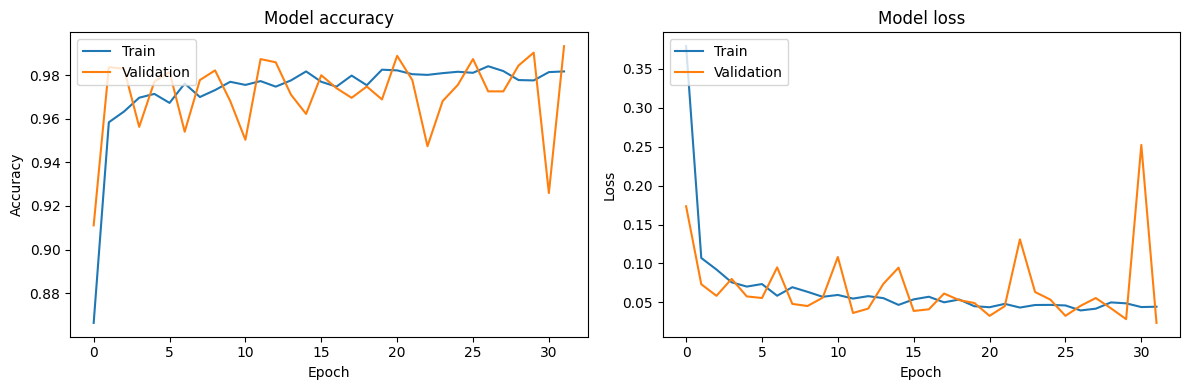

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 1, 9)]               0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 1, 9)]               0         []                            
                                                                                                  
 lstm_4 (LSTM)               (None, 1, 256)               272384    ['input_3[0][0]']             
                                                                                                  
 lstm_6 (LSTM)               (None, 1, 256)               272384    ['input_4[0][0]']             
                                                                                            

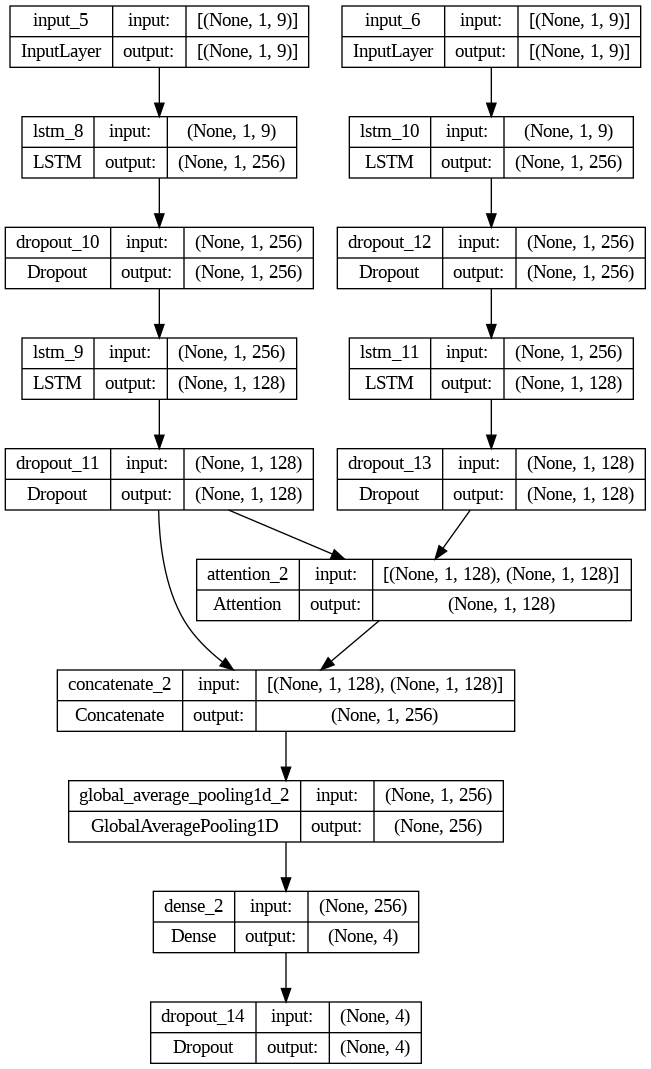

In [ ]:
create_model(optimizer_name='Adam', dropout_rate=0.0, learning_rate=0.001).summary()
print()
plot_model(create_model(optimizer_name='Adam', dropout_rate=0.0, learning_rate=0.001), to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#### 2.2.4 Model Testing

In [ ]:
y_pred_lstm = model.predict([X_test_reshaped, X_test_reshaped], batch_size=1)

# For multi-class classification, convert predictions to integer labels
predictions = np.argmax(y_pred_lstm, axis=1)

accuracy = accuracy_score(y_test, predictions)

1350/1350 [==============================] - 9s 5ms/step




---


## **3 Overal Results**

In [ ]:
def plt_ml_af(ml_models, svm, rf, lstm, xgb, figsize, ysize, ylabel):
    ml_acc_mse = [svm, rf, lstm, xgb]
    sns.set_style("whitegrid")
    plt.figure(figsize=figsize)
    plt.yticks(ysize)
    plt.ylabel(ylabel)
    plt.xlabel("Machine Learning Models")
    sns.barplot(x=ml_models, y=ml_acc_mse)
    plt.show()

def plot_classification(X_pca, y_true, y_pred, classifier_name):
    plt.figure(figsize=(6, 4))

    # Ensure y_true and y_pred are numpy arrays and have the same shape
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape")

    # Indices of correct and incorrect classifications
    correct_indices = y_true == y_pred
    incorrect_indices = y_true != y_pred

    # Scatter plot for correct classifications
    plt.scatter(X_pca[correct_indices, 0], X_pca[correct_indices, 1],
                c='green', label='Correctly Classified', alpha=0.5)

    # Scatter plot for incorrect classifications
    plt.scatter(X_pca[incorrect_indices, 0], X_pca[incorrect_indices, 1],
                c='red', label='Incorrectly Classified', alpha=0.5)

    plt.title(f'Classification accuracy for {classifier_name}')
    plt.legend()
    plt.grid(True)
    plt.show()
    print()

### 3.1 Classification Report

In [ ]:
def print_evaluation_metrics(model_name, y_true, y_pred):
    accuracy = round(accuracy_score(y_true, y_pred) * 100, 2)
    mse = round(mean_squared_error(y_true, y_pred), 2)
    print(f'____ {model_name} ____')
    print(f'Accuracy: {accuracy}%')
    print(f'Mean Squared Error (MSE): {mse}\n')

# Random Forest Evaluation
print_evaluation_metrics('Random Forest', y_test, y_pred_rf)

# Support Vector Machine Evaluation
print_evaluation_metrics('SVM', y_test, y_pred_svm)

# XG-Boost Evaluation
print_evaluation_metrics('XGBoost', y_test, y_pred_xgb)

# LSTM
lstm_predictions = np.argmax(y_pred_lstm, axis=1)
print_evaluation_metrics('LSTM', y_test, lstm_predictions)

____ Random Forest ____
Accuracy: 92.15%
Mean Squared Error (MSE): 0.08

____ SVM ____
Accuracy: 85.26%
Mean Squared Error (MSE): 0.15

____ XGBoost ____
Accuracy: 92.67%
Mean Squared Error (MSE): 0.07

____ LSTM ____
Accuracy: 99.11%
Mean Squared Error (MSE): 0.01



### 3.2 Plot the results

#### 3.2.1 Accuracy (1)

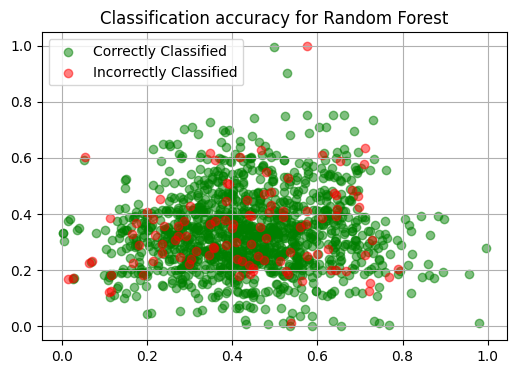

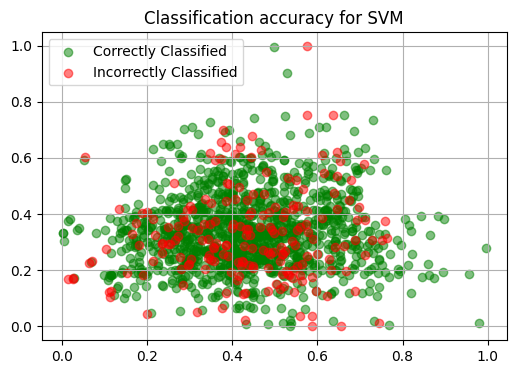

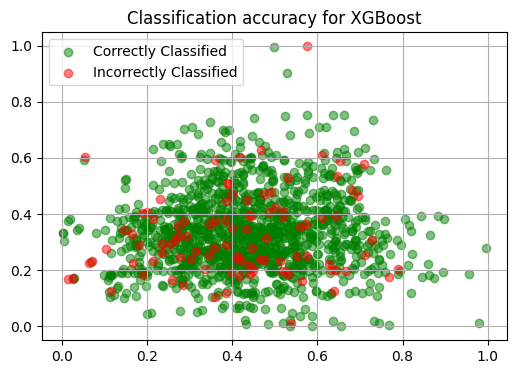

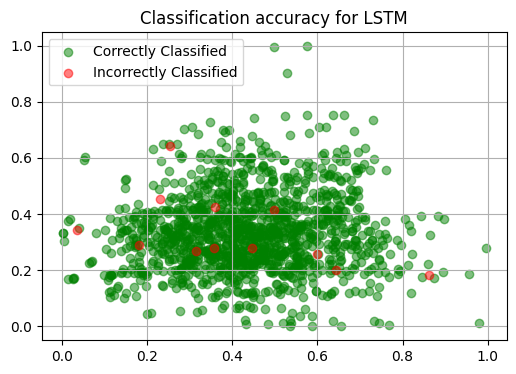

In [ ]:
#y_test_labels = np.argmax(y_test, axis=1)
plot_classification(X_test_scaled, y_test, y_pred_rf, 'Random Forest')
plot_classification(X_test_scaled, y_test, y_pred_svm, 'SVM')
plot_classification(X_test_scaled, y_test, y_pred_xgb, 'XGBoost')
plot_classification(X_test_scaled, y_test, np.argmax(y_pred_lstm, axis=1), 'LSTM')

#### 3.2.2 Accuracy (2)

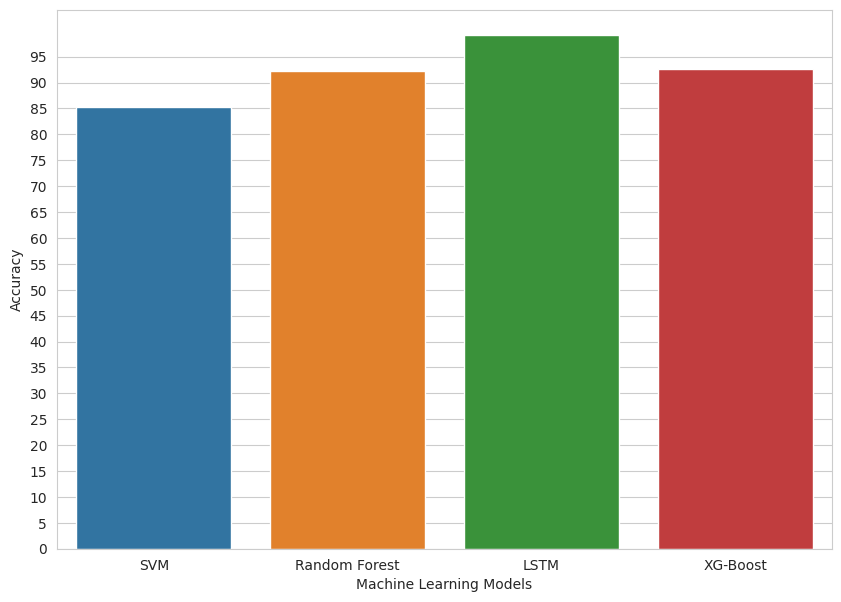

In [ ]:
lstm_predictions = np.argmax(y_pred_lstm, axis=1)
lstm_acc = round(accuracy_score(y_test, lstm_predictions) * 100, 2)

ml_models = ['SVM', 'Random Forest', 'LSTM', 'XG-Boost']
svm_acc = round(accuracy_score(y_test, y_pred_svm) * 100, 2)
xgb_acc = round(accuracy_score(y_test, y_pred_xgb) * 100, 2)
rf_acc = round(accuracy_score(y_test, y_pred_rf) * 100, 2)

plt_ml_af(ml_models, svm_acc, rf_acc, lstm_acc, xgb_acc, (10, 7), np.arange(0, 100, 5), "Accuracy")

#### 3.2.3 MSE

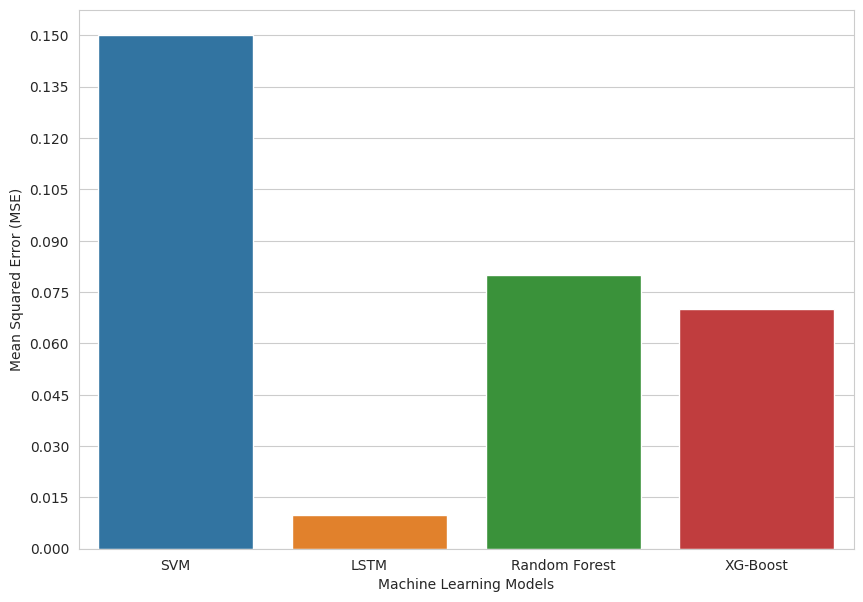

In [ ]:
ml_models = ['SVM', 'LSTM', 'Random Forest', 'XG-Boost']

svm_mse = round(mean_squared_error(y_test, y_pred_svm), 2)
xgb_mse = round(mean_squared_error(y_test, y_pred_xgb), 2)
rf_mse = round(mean_squared_error(y_test, y_pred_rf), 2)
lstm_mse = round(mean_squared_error(y_test, lstm_predictions), 2)

max_mse = max(svm_mse, lstm_mse, rf_mse, xgb_mse)
step_size = max_mse / 10

plt_ml_af(ml_models, svm_mse, lstm_mse, rf_mse, xgb_mse, (10, 7), np.arange(0, max_mse + step_size, step_size), "Mean Squared Error (MSE)")



---


## **4 Adaptive Bitrate Streaming with Q-Learning**

### 4.1 Building Q-Table

In [ ]:
state_mapping = {
    0: "low",    # Low QoE
    1: "medium", # Medium QoE
    2: "high",   # High QoE
    3: "very_high"  # Very High QoE
}
states = [state_mapping.get(score, "low") for score in df_sorted['QoE'].unique()]  # Map QoE scores to states
actions = ["low_bitrate", "medium_bitrate", "high_bitrate"]
num_states = len(np.unique(df_sorted['QoE']))

# Number of actions (bitrate levels)
num_actions = len(actions)

# Initialize Q-table with zeros
q_table = np.zeros((num_states, num_actions))

### 4.2 Action Definition

The ***choose_action*** function selects an action for a given state using an epsilon-greedy strategy, balancing between exploration and exploitation. If a random number is less than epsilon, a random action is chosen for exploration; otherwise, the action with the highest Q-value from the Q-table is selected for exploitation. This approach allows the agent to explore different actions while gradually favoring those that yield higher rewards as learned from the Q-table.

In [ ]:
def choose_action(state, q_table, epsilon):
    """
    Chooses an action based on the current state using an epsilon-greedy strategy.

    Parameters:
    - state: The current state of the environment.
    - q_table: A table storing Q-values for state-action pairs.
    - epsilon: Probability of selecting a random action (exploration factor).

    Returns:
    - The selected action, either chosen randomly for exploration or the best action
      based on the Q-table for exploitation.
    """

    # Convert the state to its corresponding index
    state_index = states.index(state)

    # Epsilon-greedy strategy for action selection
    if np.random.rand() <= epsilon:
        # Choose a random action
        return np.random.choice(actions)
    else:
        # Choose the best action from the Q-table for the current state
        action_index = np.argmax(q_table[state_index])
        return actions[action_index]

### 4.3 Learn Function


The ***learn*** function serves as a key component of the Q-learning algorithm, responsible for updating the Q-table based on the agent's experiences. It takes parameters including the current state, action taken, immediate reward, subsequent state, and uses a machine learning model for predictions. The function updates the Q-table by calculating a new Q-value for the state-action pair, incorporating both the immediate reward and the estimated future rewards, guided by the model's predictions. The learning rate *(alpha)* controls the impact of new information on the existing Q-values, and the discount factor *(gamma)* determines the weight given to future rewards. This process iteratively refines the agent's strategy, aiming to optimize actions for maximum long-term rewards in various states.

https://www.oreilly.com/library/view/hands-on-q-learning-with/9781789345803/3aa19289-1223-4770-8df2-c713a68aa969.xhtml

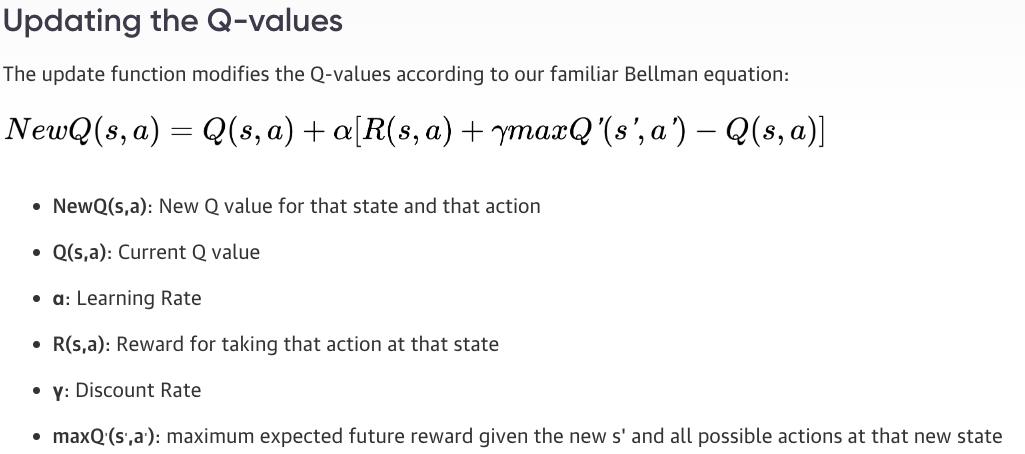

In [ ]:
def learn(state, action, reward, next_state, model, model_name, X_data, q_table, alpha=0.01, gamma=0.9):
    """
    Updates the Q-table based on the observed transition and model's prediction.

    Parameters:
    - state: The current state of the environment before taking the action.
    - action: The action taken in the current state.
    - reward: The immediate reward received after taking the action.
    - next_state: The state the environment transitions to after the action.
    - model: The ML model used for Q-value prediction.
    - model_name: The name of the ML model (e.g., 'LSTM', 'XGBoost').
    - X_data: The input data for the ML model, used for making predictions.
    - q_table: The Q-table that stores Q-values for state-action pairs.
    - alpha: The learning rate, determining how much new information affects existing Q-values.
    - gamma: The discount factor, representing the importance of future rewards.

    Returns:
    - Updated Q-table after applying the Q-learning update rule.
    """
    # Convert the current, next states and action to their respective indices
    state_index = states.index(state)
    action_index = actions.index(action)
    next_state_index = states.index(next_state)

    # Get the Q-value prediction for the next state using the specified model
    if model_name == 'LSTM':
        # If the model is an LSTM, prepare the input data and get the prediction
        lstm_input = np.expand_dims(X_data[next_state_index], axis=0)

        # The model predicts the highest probability of each class
        predicted_qoe = model.predict([lstm_input, lstm_input], verbose=0)[0]

        # We are selecting the maximum probability for a label
        predicted_q_value = np.max(predicted_qoe)
    else:
        # For other models, reshape the state features and predict
        state_features = X_data[next_state_index].reshape(1, -1)

        # The model directly predicts the value
        predicted_q_value = model.predict(state_features)[0]

    # Calculate the current Q-value for the state-action pair from the Q-table
    predict = q_table[state_index, action_index]
    # Compute the target Q-value using the reward and discounted future Q-value
    target = reward + gamma * predicted_q_value
    # Update the Q-value for the state-action pair in the Q-table
    # using the learning rate (alpha)
    q_table[state_index, action_index] += alpha * (target - predict)

    # Return the updated Q-table
    return q_table

### 4.4 The QoE Estimation

The ***calculate_QoE*** function assesses Quality of Experience (QoE) based on the selected bitrate action, rebuffering rate, and received reward. It assigns specific weightings to these factors, with preferences towards lower bitrates and higher rewards for better QoE, and penalizes for higher rebuffering rates. The function calculates a raw QoE score and normalizes it within a range of 0 to 3. The final QoE score is discretized into one of four categories (0, 1, 2, or 3), representing different levels of user satisfaction.

In [ ]:
def calculate_QoE(action, rebuffering_rate, reward):
    """
    Calculate Quality of Experience (QoE) based on bitrate action, rebuffering rate, and reward.

    Parameters:
    - action: Selected bitrate action ('low_bitrate', 'medium_bitrate', 'high_bitrate').
    - rebuffering_rate: Rate of rebuffering events.
    - reward: Reward received, indicating overall user satisfaction.

    Returns:
    - QoE: Quality of Experience score (0, 1, 2, or 3).
    """
    # Assign weightings based on action
    action_weights = {
        'low_bitrate': 1.0,   # Prefer lower bitrate for higher QoE
        'medium_bitrate': 0.5,
        'high_bitrate': -0.5   # Lower QoE for higher bitrate
    }

    # Weights for rebuffering
    weight_rebuffer = -1.0  # Negative impact on QoE

    # Calculate the raw QoE score
    raw_qoe = action_weights.get(action, 0) + (weight_rebuffer * rebuffering_rate) + reward

    # Adjust these based on the actual range of your raw_qoe
    min_qoe = -15
    max_qoe = 15

    # Normalize and scale QoE score to be within 0 to 3
    normalized_qoe = (raw_qoe - min_qoe) / (max_qoe - min_qoe) * 3

    # Discretize the QoE score into 0, 1, 2, or 3
    if normalized_qoe < 0.5:
        qoe_score = 0
    elif normalized_qoe < 1.4:
        qoe_score = 1
    elif normalized_qoe < 2.5:
        qoe_score = 2
    else:
        qoe_score = 3

    return qoe_score

### 4.5 Reward Function

The ***calculate_reward*** function determines the reward for a specific action taken during video streaming, based on the bitrate choice and whether rebuffering occurred. It assigns predefined reward values to each bitrate action: a high positive reward (25) for choosing a low bitrate, a moderate positive reward (10) for a medium bitrate, and a negative reward (-5) for a high bitrate. These values indicate the preference or penalty associated with each bitrate option, where lower bitrates are preferred (possibly due to lower likelihood of rebuffering), and higher bitrates are penalized (potentially due to increased rebuffering risk). If rebuffering occurs, the reward for the chosen bitrate action is negated, turning a positive reward into a penalty or exacerbating an existing penalty. This reflects the adverse impact of rebuffering on user experience, where even a low bitrate selection is penalized if it leads to playback interruptions.

In [ ]:
def calculate_reward(chunk_data, action, rebuffering_occurred):
    # Implement reward calculation logic here
    # Placeholder values for demonstration
    reward_values = {'low_bitrate': 25, 'medium_bitrate': 10, 'high_bitrate': -5}
    return reward_values[action] if not rebuffering_occurred else -reward_values[action]

### 4.6 Chunk Playback Simulation

The ***simulate_chunk_playback*** function mimics the process of streaming a video chunk and calculates the associated reward and rebuffering occurrence. It assigns a predefined probability of rebuffering for each bitrate action: 10% for low bitrate, 20% for medium, and 30% for high. The actual occurrence of rebuffering is determined randomly based on these probabilities. If rebuffering occurs, it negatively impacts the reward received for the chosen action. The function then returns two values: the calculated reward (which varies depending on whether rebuffering occurred and the chosen bitrate) and a boolean indicating whether rebuffering occurred during the chunk's playback. This function essentially models the trade-off between higher bitrates (and their associated higher quality but increased risk of rebuffering) and lower bitrates (with reduced quality but more stable playback).

In [ ]:
def simulate_chunk_playback(chunk_data, action):
    # This function should simulate the playback of a video chunk based on the chosen action.
    # It should return the reward (e.g., based on QoE, bitrate, etc.) and whether rebuffering occurred.

    # Placeholder implementation
    rebuffering_probability = {'low_bitrate': 0.1, 'medium_bitrate': 0.2, 'high_bitrate': 0.3}

    # It will be True or False
    rebuffering_occurred = np.random.rand() < rebuffering_probability[action]

    reward = calculate_reward(chunk_data, action, rebuffering_occurred)

    return reward, rebuffering_occurred

### 4.7 Policy Evaluation


This function evaluates the performance of a policy (encoded in the model) on a set of video chunks (X_test). It simulates the process of streaming video chunks, applying a learned policy to decide on bitrate actions for each chunk. The function tracks various metrics including rewards, rebuffering rates, and Quality of Experience (QoE) for each chunk and overall video.

In [ ]:
def evaluate_policy(X_test, num_chunks=100, model=xgb_clf, model_name=None, q_table=None):
    # Initialize variables for tracking metrics
    total_avg_reward = 0
    default_btr = "low"
    num_videos = len(X_test) // num_chunks
    total_rebuffering_rate = 0
    total_QoE = 0
    total_bitrate_distribution = {action: 0 for action in actions}
    chunk_bitrate_actions = []
    chunk_rebuffering_rates = []
    chunk_QoEs = []

    # Iterate through each video
    for video_idx in range(num_videos):
        rewards = []
        rebuffering_events = 0
        bitrate_distribution = {action: 0 for action in actions}

        # Process each chunk of the video
        for chunk_idx in range(num_chunks):
            # Extract chunk data
            chunk_data = X_test[video_idx * num_chunks + chunk_idx]
            # Determine the current state based on the QoE
            current_state = state_mapping.get(y_test.iloc[video_idx * num_chunks + chunk_idx], default_btr)

            # Choose an action based on the current state using Q-table
            action = choose_action(current_state, q_table, epsilon=0.05)
            chunk_bitrate_actions.append(action)

            # Simulate chunk playback to get reward and check if rebuffering occurred
            reward, rebuffered = simulate_chunk_playback(chunk_data, action)

            # Count rebuffering events
            if rebuffered:
                rebuffering_events += 1

            # Accumulate the rewards obtained for each chunk
            rewards.append(reward)
            # Update the count of how often each action (bitrate level) was chosen
            bitrate_distribution[action] += 1

            # Calculate the index for the next chunk
            next_chunk_idx = video_idx * num_chunks + chunk_idx + 1

            # Determine the next state based on the QoE of the next chunk
            if chunk_idx < num_chunks - 1:
                next_state = state_mapping.get(y_test.iloc[next_chunk_idx], default_btr)
            else:
                next_state = current_state  # Use the initial state if it's the last chunk

            # Update the Q-table based on the observed transition
            q_table = learn(current_state, action, reward, next_state, model, model_name, X_test, q_table, alpha=0.01, gamma=0.9)

            # Update the current state to the next state for the next iteration
            current_state = next_state

            # Calculate rebuffering rate and QoE for each chunk (Zero based)
            chunk_rebuffering_rate = rebuffering_events / (chunk_idx + 1)
            chunk_rebuffering_rates.append(chunk_rebuffering_rate)
            chunk_QoE = calculate_QoE(action, chunk_rebuffering_rate, reward)
            total_QoE += chunk_QoE
            total_rebuffering_rate += chunk_rebuffering_rate
            chunk_QoEs.append(chunk_QoE)

        # Update the overall bitrate distribution
        for action in actions:
            total_bitrate_distribution[action] += bitrate_distribution[action]

        # Calculate average reward and rebuffering rate for each video
        avg_reward = np.mean(rewards)
        rebuffering_rate = rebuffering_events / num_chunks
        QoE = calculate_QoE(action, chunk_rebuffering_rate, avg_reward)
        total_avg_reward += avg_reward

    # Normalize the overall bitrate distribution
    total_chunks = num_videos * num_chunks
    for action in actions:
        total_bitrate_distribution[action] /= total_chunks

    # Calculate and print overall metrics
    overall_avg_reward = total_avg_reward / num_videos
    overall_rebuffering_rate = total_rebuffering_rate / len(chunk_rebuffering_rates)
    overall_QoE = total_QoE / len(chunk_QoEs)
    overall_QoE_rounded = overall_QoE
    overall_rebuffering_rate_scaled = round(overall_rebuffering_rate * 100, 2)

    print(f"Overall Average Reward of {model_name}: {overall_avg_reward}")
    print(f"Overall Rebuffering Rate: {overall_rebuffering_rate_scaled} %")
    print(f"Overall Quality of Experience (QoE): {overall_QoE_rounded}")
    print(f"Overall Bitrate Distribution of {model_name}: {total_bitrate_distribution}")

    # Plot the distribution of chosen bitrates
    plt.bar(total_bitrate_distribution.keys(), total_bitrate_distribution.values())
    plt.xlabel('Bitrate Actions')
    plt.ylabel('Frequency')
    plt.title(f"Overall Bitrate Distribution of {model_name}")
    plt.show()

    # Return collected data for further analysis
    return chunk_bitrate_actions, chunk_rebuffering_rates, chunk_QoEs

### 4.8 Evaluation and Testing

In [ ]:
def plot_rebuffering_rate(rebuffering_rates, model_name):
    plt.figure(figsize=(10, 5))
    plt.plot(rebuffering_rates, label='Rebuffering Rate', color='blue')
    plt.xlabel('Chunk Number')
    plt.ylabel('Rebuffering Rate')
    plt.title(f'Rebuffering Rate per Chunk of {model_name}')
    plt.legend()
    plt.show()

def plot_QoE(QoEs, model_name):
    plt.figure(figsize=(10, 5))
    plt.bar(list(range(len(QoEs))), QoEs, color='green')
    plt.xlabel('Chunk Number')
    plt.ylabel('QoE')
    plt.title(f'Quality of Experience (QoE) per Chunk  of {model_name}')
    plt.xticks(list(range(len(QoEs))))
    plt.show()

#### 4.8.1 XGBoost

Overall Average Reward of XGBoost: 19.455555555555556
Overall Rebuffering Rate: 10.91 %
Overall Quality of Experience (QoE): 2.6777777777777776
Overall Bitrate Distribution of XGBoost: {'low_bitrate': 0.965925925925926, 'medium_bitrate': 0.017037037037037038, 'high_bitrate': 0.017037037037037038}


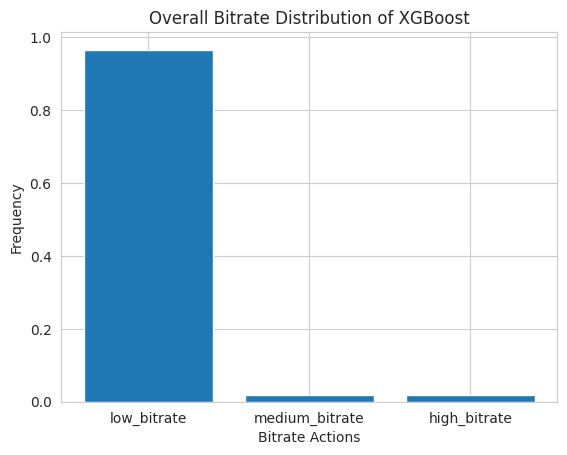

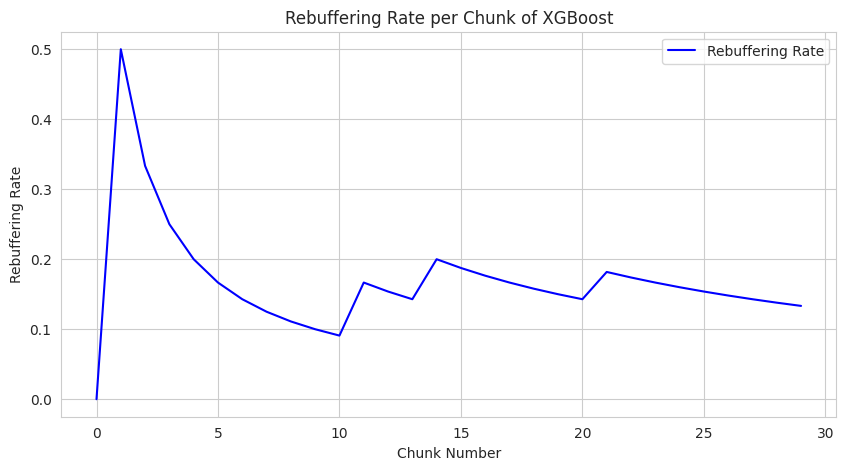

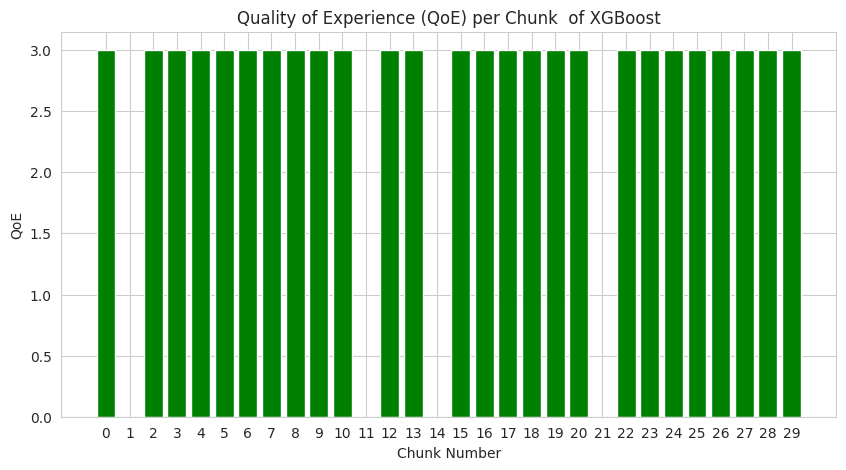

In [ ]:
chunk_bitrate_actions_XGBoost, chunk_rebuffering_rates_XGBoost, chunk_QoEs_XGBoost = evaluate_policy(X_test_scaled, model=xgb_clf, model_name='XGBoost', q_table=np.zeros((num_states, num_actions)), num_chunks=1350)
plot_rebuffering_rate(chunk_rebuffering_rates_XGBoost[:30], 'XGBoost')
plot_QoE(chunk_QoEs_XGBoost[:30], 'XGBoost')

#### 4.8.2 Random Forest

Overall Average Reward of Random Forest: 19.374074074074073
Overall Rebuffering Rate: 9.3 %
Overall Quality of Experience (QoE): 2.6814814814814816
Overall Bitrate Distribution of Random Forest: {'low_bitrate': 0.9614814814814815, 'medium_bitrate': 0.022962962962962963, 'high_bitrate': 0.015555555555555555}


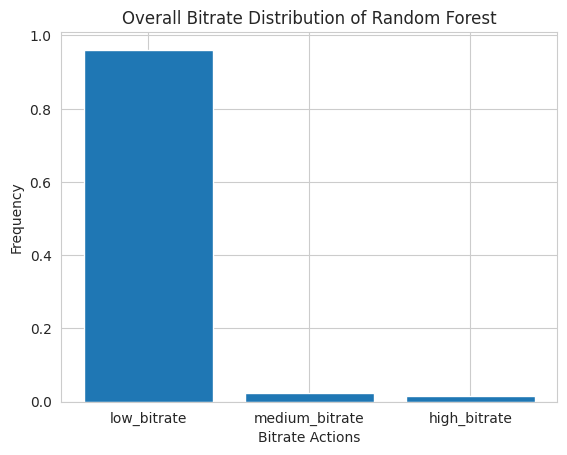

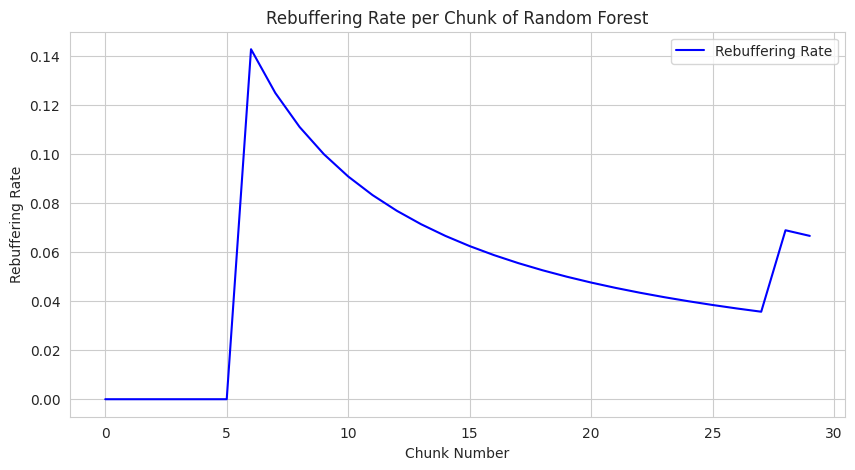

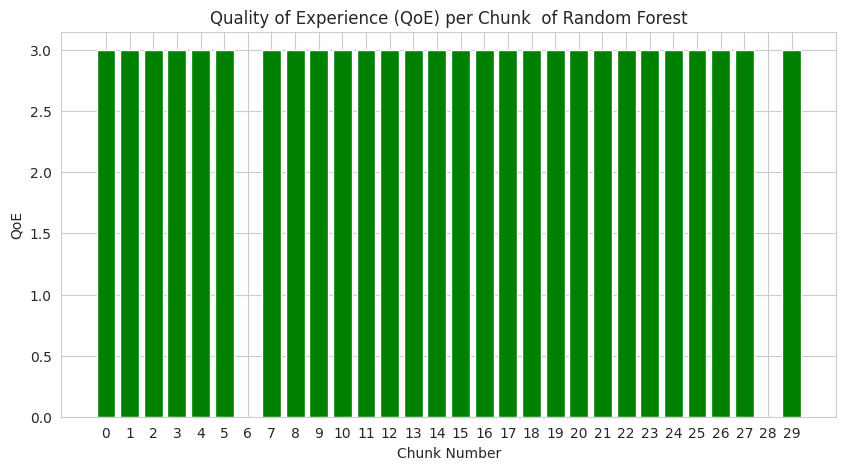

In [ ]:
chunk_bitrate_actions_rf, chunk_rebuffering_rates_rf, chunk_QoEs_rf = evaluate_policy(X_test_scaled, model=random_forest_clf, model_name='Random Forest', q_table=np.zeros((num_states, num_actions)), num_chunks=1350)
plot_rebuffering_rate(chunk_rebuffering_rates_rf[:30], 'Random Forest')
plot_QoE(chunk_QoEs_rf[:30], 'Random Forest')

#### 4.8.3 Support Vector Machine

Overall Average Reward of SVM: 18.655555555555555
Overall Rebuffering Rate: 11.89 %
Overall Quality of Experience (QoE): 2.676296296296296
Overall Bitrate Distribution of SVM: {'low_bitrate': 0.8962962962962963, 'medium_bitrate': 0.08222222222222222, 'high_bitrate': 0.02148148148148148}


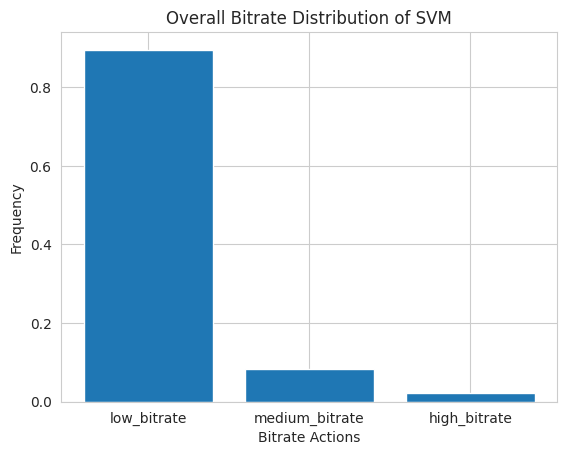

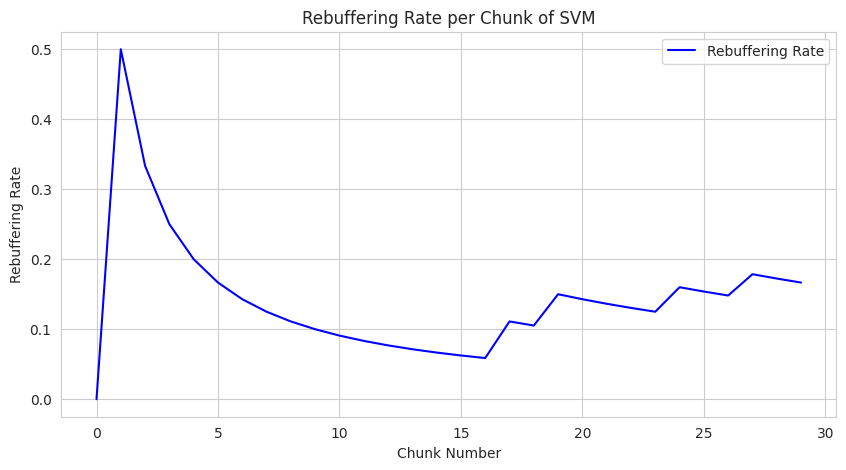

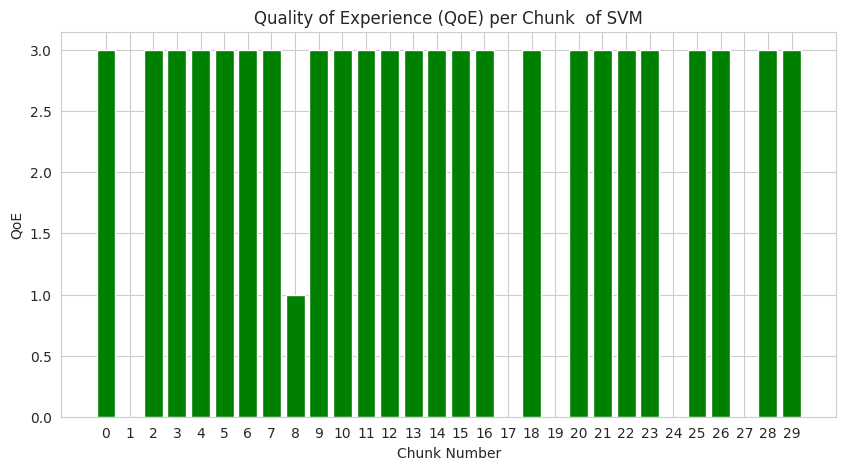

In [ ]:
chunk_bitrate_actions_SVM, chunk_rebuffering_rates_SVM, chunk_QoEs_SVM = evaluate_policy(X_test_scaled, model=svm_clf, model_name='SVM', q_table=np.zeros((num_states, num_actions)), num_chunks=1350)
plot_rebuffering_rate(chunk_rebuffering_rates_SVM[:30], 'SVM')
plot_QoE(chunk_QoEs_SVM[:30], 'SVM')

#### 4.8.4 Long Short-Term Memory (LSTM)

Overall Average Reward of LSTM: 19.703703703703702
Overall Rebuffering Rate: 9.84 %
Overall Quality of Experience (QoE): 2.6874074074074072
Overall Bitrate Distribution of LSTM: {'low_bitrate': 0.9703703703703703, 'medium_bitrate': 0.013333333333333334, 'high_bitrate': 0.016296296296296295}


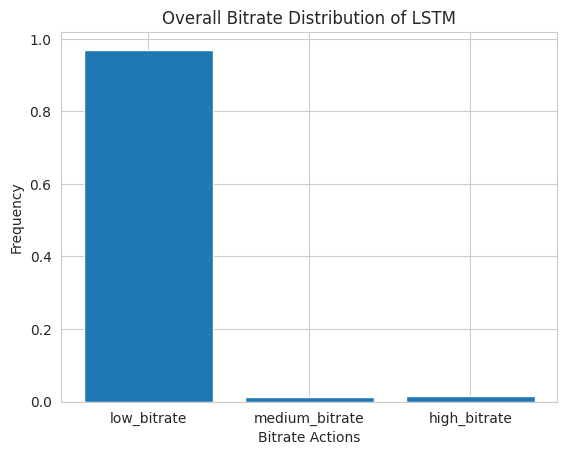

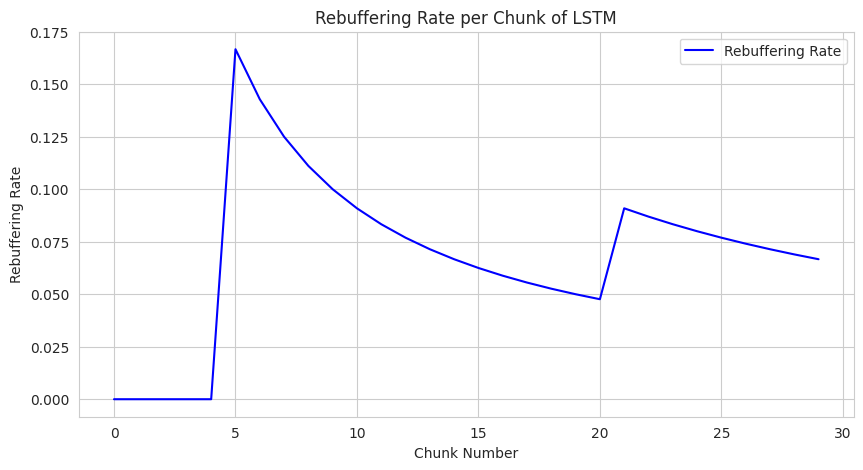

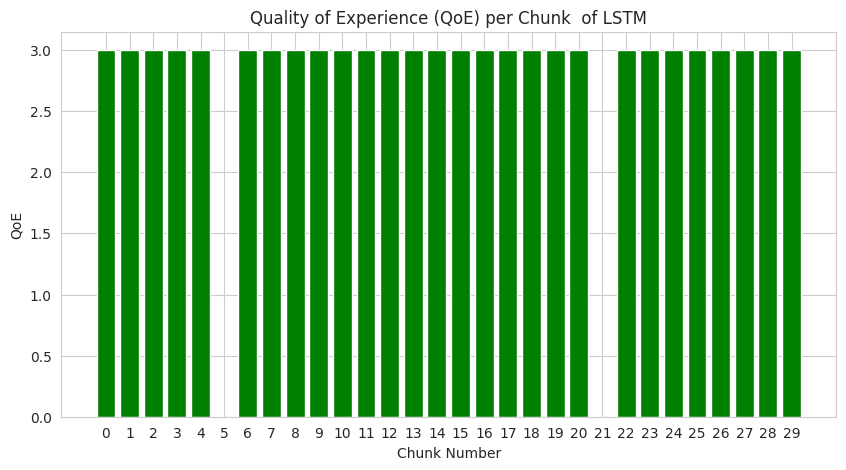

In [ ]:
chunk_bitrate_actions_nn, chunk_rebuffering_rates_nn, chunk_QoEs_nn = evaluate_policy(X_test_reshaped, model=model, model_name='LSTM', q_table=np.zeros((num_states, num_actions)), num_chunks=1350)
plot_rebuffering_rate(chunk_rebuffering_rates_nn[:30], 'LSTM')
plot_QoE(chunk_QoEs_nn[:30], 'LSTM')

### 4.9 Real-World Testing with YouTube Video

In [ ]:
download_dir = '/content/drive/MyDrive/Private/Bahador/Concordia University/6- Fall 2023/COMP 691/Project/Dataset/TestVids'
encoded_dir = '/content/drive/MyDrive/Private/Bahador/Concordia University/6- Fall 2023/COMP 691/Project/Dataset/TestVidsEncoded'

def get_youtube_links():
    links = []
    return input("Enter link: ")

# This link Can be used for testing
# https://www.youtube.com/watch?v=YgI1CeaGX8A

def get_video_bitrate(video_path):
    """
    Extracts the bitrate of a video file using FFmpeg.

    Parameters:
    - video_path: Path to the video file.

    Returns:
    - Bitrate of the video in kbps.
    """
    command = ["ffmpeg", "-i", video_path, "-hide_banner"]
    process = subprocess.Popen(command, stderr=subprocess.PIPE, stdout=subprocess.PIPE)
    stdout, stderr = process.communicate()
    match = re.search(r'bitrate: (\d+) kb/s', stderr.decode())
    if match:
        return int(match.group(1))
    return None

def get_video_resolution(video_path):
    """
    Extracts the resolution of a video file using FFmpeg.

    Parameters:
    - video_path: Path to the video file.

    Returns:
    - Resolution of the video as a tuple (width, height).
    """
    command = ["ffprobe", "-v", "error", "-select_streams", "v:0", "-show_entries", "stream=width,height", "-of", "csv=p=0", video_path]
    process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, _ = process.communicate()
    resolution_info = stdout.decode().strip()
    if resolution_info:
        width, height = resolution_info.split(',')
        return int(width), int(height)
    return None, None

def download_and_transcode_video(url, video_id):
    try:
        yt = YouTube(url)
        stream = yt.streams.filter(progressive=True, file_extension='mp4').order_by('resolution').desc().first()
        original_path = os.path.join(download_dir, f"{video_id}.mp4")

        # Check if original file already exists
        if not os.path.exists(original_path):
            stream.download(output_path=download_dir, filename=f"{video_id}.mp4")
            print(f"Downloaded original {url} to {original_path}")
        else:
            print(f"Original file already exists: {original_path}")

        # Transcode to all combinations in bitrate_ladder
        for step in bitrate_ladder:
            resolution = step['resolution']
            for bitrate in [step['bitrate_min'], step['bitrate_default'], step['bitrate_max']]:
                output_path = os.path.join(encoded_dir, f"{video_id}_{resolution}_{bitrate}k.mp4")
                # Check if transcoded file already exists
                if not os.path.exists(output_path):
                    ffmpeg_command = f"ffmpeg -y -i {shlex.quote(original_path)} -s {resolution} -b:v {bitrate}k -c:a copy {shlex.quote(output_path)}"
                    ffmpeg_args = shlex.split(ffmpeg_command)
                    with subprocess.Popen(ffmpeg_args, stderr=subprocess.PIPE, stdout=subprocess.PIPE) as process:
                        output, error = process.communicate()
                        if process.returncode != 0:
                            print(f"FFmpeg error: {error.decode()}")
                        else:
                            print(f"Transcoded to {output_path}")
                else:
                    print(f"Transcoded file already exists: {output_path}")

    except Exception as e:
        print(f"Error in processing {url}: {e}")

def find_closest_bitrate_category(bitrate, resolution, bitrate_ladder):
    closest_category = None
    min_difference = float('inf')

    resolution_str = f"{resolution[0]}x{resolution[1]}"
    for step in bitrate_ladder:
        if step['resolution'] == resolution_str:
            for category in ['bitrate_min', 'bitrate_default', 'bitrate_max']:
                difference = abs(bitrate - step[category])
                if difference < min_difference:
                    min_difference = difference
                    closest_category = category
            break

    return closest_category

# Transcode and process videos
link = get_youtube_links()
video_id = link.split("=")[-1]
download_and_transcode_video(link, video_id)
bitrates = []
resolutions = []

video_files = [f for f in os.listdir(download_dir) if f.endswith('.mp4')]
for video_file in video_files:
    video_path = os.path.join(download_dir, video_file)
    bitrate = get_video_bitrate(video_path)
    bitrates.append(bitrate)
    resolution = get_video_resolution(video_path)
    resolutions.append(resolution)
# Extract features and create dataset
youtube_features, youtube_bitrates, youtube_video_names = create_dataset(encoded_dir, download_dir, bitrate_ladder)

# Convert results to a DataFrame for easy handling
df = pd.DataFrame(youtube_features, columns=['PSNR', 'R_Var', 'G_Var', 'B_Var', 'Frame_Diff', 'DCT_Mean', 'DCT_Var'])
df['Bitrate_Label'] = youtube_bitrates
df['Video_Name'] = youtube_video_names
df.head()

#### 4.9.0 Saving encoded features

In [ ]:
np.save('/content/drive/MyDrive/Private/Bahador/Concordia University/6- Fall 2023/COMP 691/Project/Dataset/youtube_features_values.npy', youtube_features)
np.save('/content/drive/MyDrive/Private/Bahador/Concordia University/6- Fall 2023/COMP 691/Project/Dataset/youtube_bitrate_values.npy', youtube_bitrates)
np.save('/content/drive/MyDrive/Private/Bahador/Concordia University/6- Fall 2023/COMP 691/Project/Dataset/youtube_video_files_values.npy', youtube_video_names)

#### 4.9.1 Extracting the real Resolution and Bitrate

In [ ]:
youtube_features = np.load('/content/drive/MyDrive/Private/Bahador/Concordia University/6- Fall 2023/COMP 691/Project/Dataset/features.npy')
youtube_bitrates = np.load('/content/drive/MyDrive/Private/Bahador/Concordia University/6- Fall 2023/COMP 691/Project/Dataset/bitrates.npy')
youtube_video_names = np.load('/content/drive/MyDrive/Private/Bahador/Concordia University/6- Fall 2023/COMP 691/Project/Dataset/video_files.npy')

In [ ]:
print("Bitrates of the original videos:", bitrates)
print("Resolutions of the original videos:", resolutions)

# Assuming bitrates and resolutions are lists of the same length
for i in range(len(bitrates)):
    closest_category = find_closest_bitrate_category(bitrates[i], resolutions[i], bitrate_ladder)
    print(f"The Closest bitrate category for the unencoded YouTube video is: {closest_category}")

Bitrates of the original videos: [2104]
Resolutions of the original videos: [(1280, 720)]
The Closest bitrate category for the unencoded YouTube video is: bitrate_default


#### 4.9.2 Building Features

In [ ]:
# Selecting relevant feature columns for X_test_youtube

resolutions_array = np.array([filename.split('_')[1] for filename in youtube_video_names]).reshape(-1, 1)
# Concatenate resolutions with X
features_resolution = np.hstack([youtube_features, resolutions_array])

data = np.hstack([features_resolution, youtube_bitrates.reshape(-1, 1)])  # Ensure y is a column vector

# Create a DataFrame
column_names = name + ['BITRATE']
df = pd.DataFrame(data, columns=column_names)
df['Video_File'] = youtube_video_names  # Add the video file names as a column
df = df.sort_values(by='Video_File')

# Apply the mapping to convert the 'Label' and 'Resolution' columns
df['Resolution_Score'] = df['RES'].apply(map_resolution)
df['Bitrate_Score'] = df['BITRATE'].apply(map_bitrate)

# Drop the original 'Label' and 'Resolution' columns
df.drop(['BITRATE', 'RES'], axis=1, inplace=True)
X_test_youtube = df[['PSNR', 'R_Var', 'G_Var', 'B_Var', 'Frame_Diff', 'DCT_Mean', 'DCT_Var','Resolution_Score', 'Bitrate_Score']].values

X_test_youtube_df = pd.DataFrame(X_test_youtube, columns=['PSNR', 'R_Var', 'G_Var', 'B_Var', 'Frame_Diff', 'DCT_Mean', 'DCT_Var', 'Resolution_Score', 'Bitrate_Score'])

# Applying the scaling
X_test_youtube_scaled = scaler.transform(X_test_youtube_df)

#### 4.9.3 Testing

Overall Average Reward of SVM: 18.333333333333332
Overall Rebuffering Rate: 6.27 %
Overall Quality of Experience (QoE): 2.6
Overall Bitrate Distribution of SVM: {'low_bitrate': 1.0, 'medium_bitrate': 0.0, 'high_bitrate': 0.0}


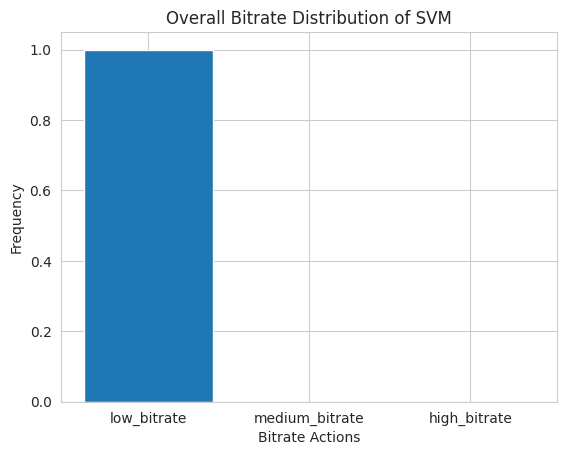

In [ ]:
chunk_bitrate_actions_SVM_youtube, chunk_rebuffering_rates_SVM_youtube, chunk_QoEs_SVM_youtube = evaluate_policy(X_test_youtube_scaled, model=svm_clf, model_name='SVM', q_table=np.zeros((num_states, num_actions)), num_chunks=15)

Overall Average Reward of RF: 21.666666666666668
Overall Rebuffering Rate: 2.6 %
Overall Quality of Experience (QoE): 2.8
Overall Bitrate Distribution of RF: {'low_bitrate': 1.0, 'medium_bitrate': 0.0, 'high_bitrate': 0.0}


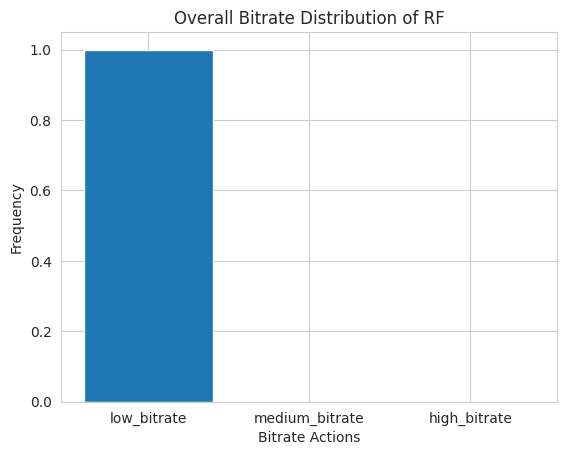

In [ ]:
chunk_bitrate_actions_RF_youtube, chunk_rebuffering_rates_RF_youtube, chunk_QoEs_RF_youtube = evaluate_policy(X_test_youtube_scaled, model=random_forest_clf, model_name='RF', q_table=np.zeros((num_states, num_actions)), num_chunks=15)

Overall Average Reward of XGB: 21.666666666666668
Overall Rebuffering Rate: 12.12 %
Overall Quality of Experience (QoE): 2.8
Overall Bitrate Distribution of XGB: {'low_bitrate': 1.0, 'medium_bitrate': 0.0, 'high_bitrate': 0.0}


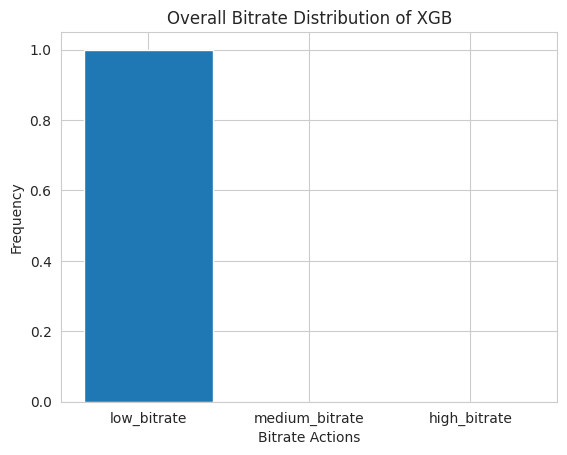

In [ ]:
chunk_bitrate_actions_XGB_youtube, chunk_rebuffering_rates_XGB_youtube, chunk_QoEs_XGB_youtube = evaluate_policy(X_test_youtube_scaled, model=xgb_clf, model_name='XGB', q_table=np.zeros((num_states, num_actions)), num_chunks=15)

Overall Average Reward of LSTM: 23.0
Overall Rebuffering Rate: 0.0 %
Overall Quality of Experience (QoE): 2.8666666666666667
Overall Bitrate Distribution of LSTM: {'low_bitrate': 0.9333333333333333, 'medium_bitrate': 0.0, 'high_bitrate': 0.06666666666666667}


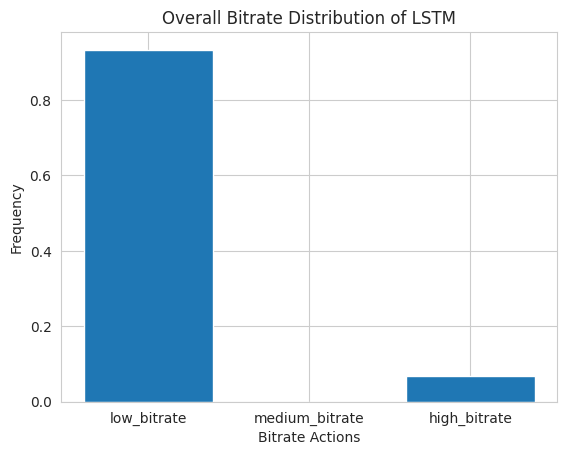

In [ ]:
X_test_youtube_scaled_reshaped = X_test_youtube_scaled.reshape((X_test_youtube_scaled.shape[0], time_steps, features_per_step))
chunk_bitrate_actions_NN_youtube, chunk_rebuffering_rates_NN_youtube, chunk_QoEs_NN_youtube = evaluate_policy(X_test_youtube_scaled_reshaped, model=model, model_name='LSTM', q_table=np.zeros((num_states, num_actions)), num_chunks=15)